# Postprocessing a Feed-Forward NN Trained for the Source Terms of a Mass-Spring-Damper System 

In [1]:
### Loading Libraries

import os
import sys
import numpy                              as np
import pandas                             as pd

import matplotlib
from matplotlib                           import pyplot as plt
WORKSPACE_PATH  = os.environ['WORKSPACE_PATH']
plt.style.use(WORKSPACE_PATH+'/ROMNet/romnet/extra/postprocessing/presentation.mplstyle')

import romnet                             as rmnt

In [2]:
### Defining ODE and its Parameters

from scipy.integrate import solve_ivp

def fOrig(t, y):
    return [y[1], -Params[2]/Params[0]*y[0]-Params[1]/Params[0]*y[1]]

def fOrig_Source(t, y):
    return [y[1], -Params[2]/Params[0]*y[0]-Params[1]/Params[0]*y[1]]

Params = np.array([1.0, 0.5, 3.0], dtype=np.float64)

In [3]:
### Input Data

ROMNet_fld    = WORKSPACE_PATH + '/ROMNet/romnet/'
path_to_run_fld  = WORKSPACE_PATH + '/ROMNet/MSD_10Cases/FNN-SourceTerms/Deterministic/Run_1/'
#path_to_run_fld  = WORKSPACE_PATH + '/ROMNet/MSD_10Cases/FNN-SourceTerms/MCDropOut/Run_1/'
#path_to_run_fld  = WORKSPACE_PATH + '/ROMNet/MSD_10Cases/FNN-SourceTerms/BayesByBackprop/Run_1/'
#path_to_run_fld  = WORKSPACE_PATH + '/ROMNet/MSD_10Cases/FNN-SourceTerms/HamiltonianMC/Run_1/'

TrainingCases = [0]#[0,2,4,6,8]
TestCases     = [0]#[0,2]

NSamples      = 30

Nt            = 100
tout          = np.linspace(0.,15.,Nt)
SOLVER        = 'Radau'
rtol          = 1.e-12 #1.e-15

In [4]:
print("\n[ROMNet]: Reading Input File from: ", path_to_run_fld)
sys.path.insert(0, path_to_run_fld)

print("\n[ROMNet]: Keep Loading Modules and Functions...")
from ROMNet_Input import inputdata

print("\n[ROMNet]: Initializing Input ...")
InputData               = inputdata(WORKSPACE_PATH, ROMNet_fld)


InputData.InputFilePath = path_to_run_fld+'/ROMNet_Input.py'
InputData.train_int_flg   = 0
InputData.path_to_run_fld  = path_to_run_fld


[ROMNet]: Reading Input File from:  /Users/sventuri/WORKSPACE//ROMNet/MSD_10Cases/FNN-SourceTerms/Deterministic/Run_1/

[ROMNet]: Keep Loading Modules and Functions...

[ROMNet]: Initializing Input ...


In [5]:
surrogate_type = InputData.surrogate_type
if (surrogate_type == 'FNN-SourceTerms'):
    surrogate_type = 'FNN'

Net   = getattr(rmnt.nn, surrogate_type)

model = rmnt.model.Model_Deterministic(InputData)

model.build(InputData, None, Net)

NN    = model.net


[ROMNet]:   Initializing the ML Model

[ROMNet]:   Building the ML Model

[ROMNet]:   Loading ML Model Parameters from File:  /Users/sventuri/WORKSPACE//ROMNet/MSD_10Cases/FNN-SourceTerms/Deterministic/Run_1//Training/Params//000989.h5
'load_params' took 0.019312 s


[ROMNet]:   Saving ML Model Parameters to File:  /Users/sventuri/WORKSPACE//ROMNet/MSD_10Cases/FNN-SourceTerms/Deterministic/Run_1//Model/Params/Initial.h5
'save_params' took 0.014902 s

'build' took 0.484325 s



In [6]:
### Evaluating on Training Data

FileName  = InputData.path_to_data_fld + '/train/ext/' + InputData.InputFiles['ext']
InputDF   = pd.read_csv(FileName, header=0)
Input     = InputDF[InputData.InputVars].to_numpy()
VarNames  = list(InputDF.columns)
Nu        = Input.shape[1]
u         = []
for iu in range(Nu):
    u.append(np.unique(Input[:,iu]))
u         = np.stack(u, axis=0).T

FileName  = InputData.path_to_data_fld + '/train/ext/' + InputData.OutputFiles['ext']
OutputDF  = pd.read_csv(FileName, header=0)
Output    = OutputDF[InputData.OutputVars].to_numpy()

Text(0.5, 0, 'dv')

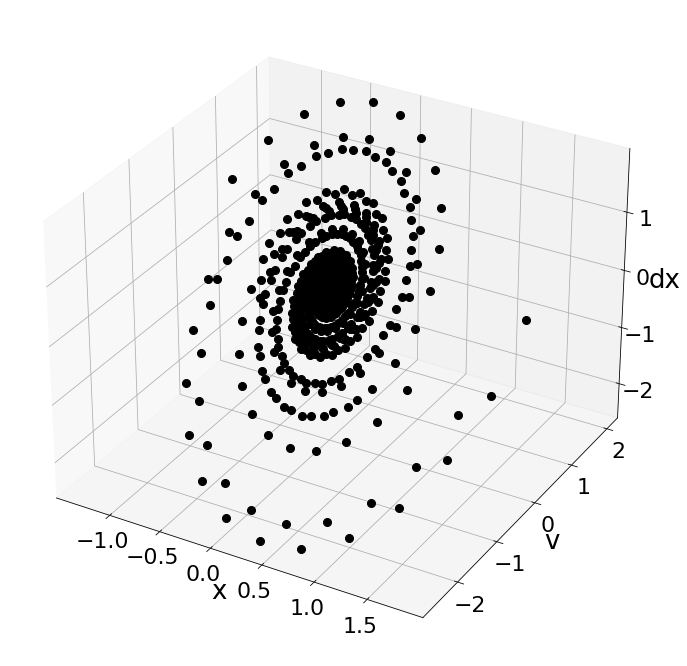

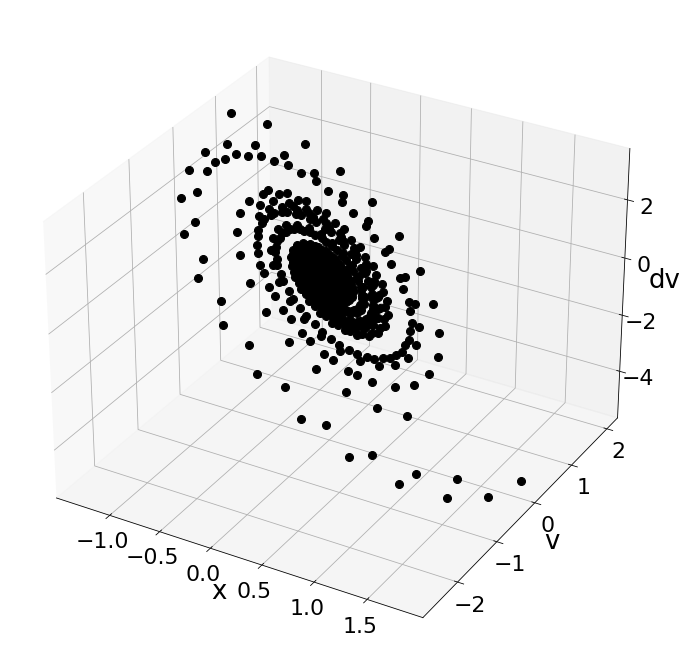

In [7]:
# Plotting Sources vs States

fig  = plt.figure(figsize=(16,12))
ax   = plt.axes(projection='3d')
ax.plot3D(InputDF[InputData.InputVars[0]], InputDF[InputData.InputVars[1]], OutputDF[InputData.OutputVars[0]], 'ok',  linewidth=2)
ax.set_xlabel(InputData.InputVars[0])
ax.set_ylabel(InputData.InputVars[1])
ax.set_zlabel(InputData.OutputVars[0])

fig  = plt.figure(figsize=(16,12))
ax   = plt.axes(projection='3d')
ax.plot3D(InputDF[InputData.InputVars[0]], InputDF[InputData.InputVars[1]], OutputDF[InputData.OutputVars[1]], 'ok',  linewidth=2)
ax.set_xlabel(InputData.InputVars[0])
ax.set_ylabel(InputData.InputVars[1])
ax.set_zlabel(InputData.OutputVars[1])

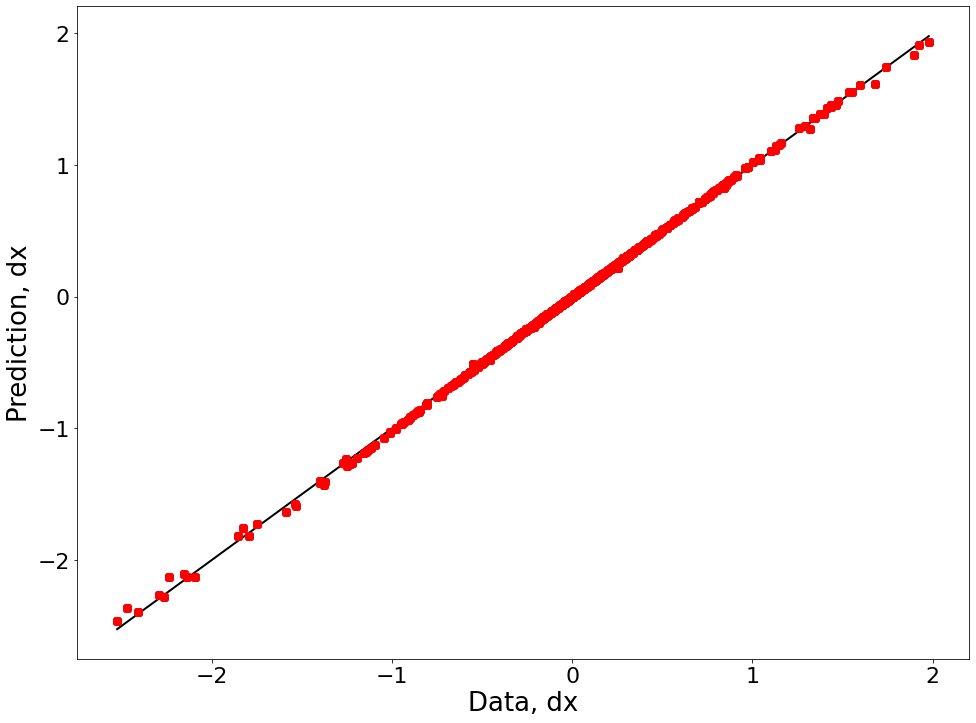

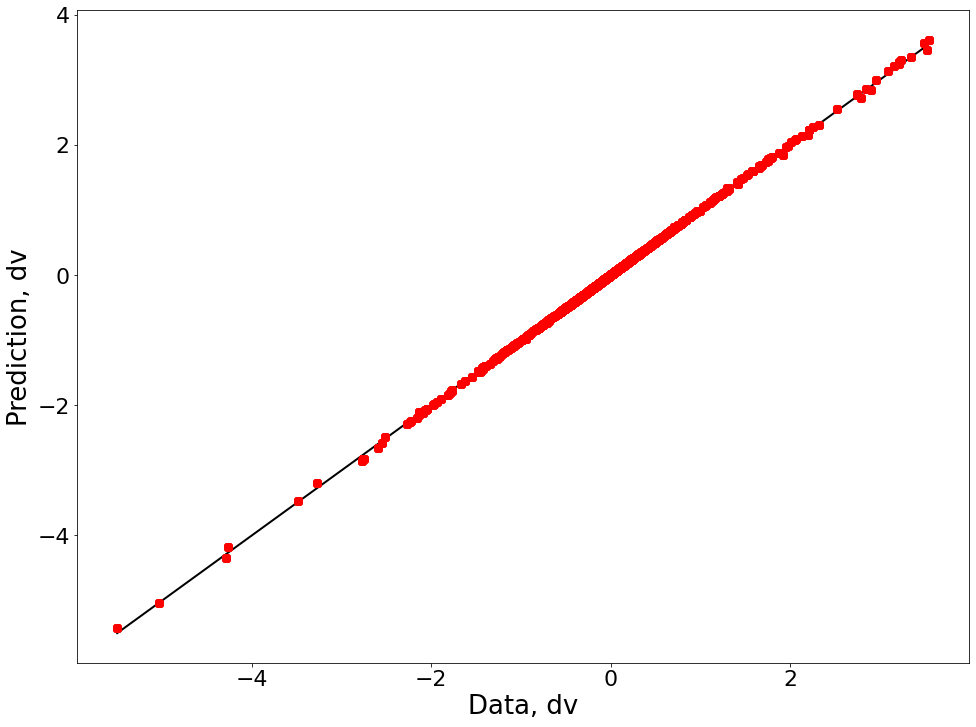

In [8]:
Ny   = len(InputData.OutputVars)
ax   = []
for iy in range(Ny):
    fig    = plt.figure(figsize=(16,12))
    ax.append(plt.axes())
    xMin_  = np.amin(Output[:,iy])
    xMax_  = np.amax(Output[:,iy])
    ax[iy].plot([xMin_,xMax_],[xMin_,xMax_],'k-')
    ax[iy].set_xlabel('Data, '+InputData.OutputVars[iy])
    ax[iy].set_ylabel('Prediction, '+InputData.OutputVars[iy])
    
for iSample in range(NSamples):
    yMat = NN.predict(InputDF[InputData.InputVars])
    for iy in range(Ny):
        ax[iy].plot(Output[:,iy], yMat[:,iy], 'ro')

Text(0.5, 0, 'dv')

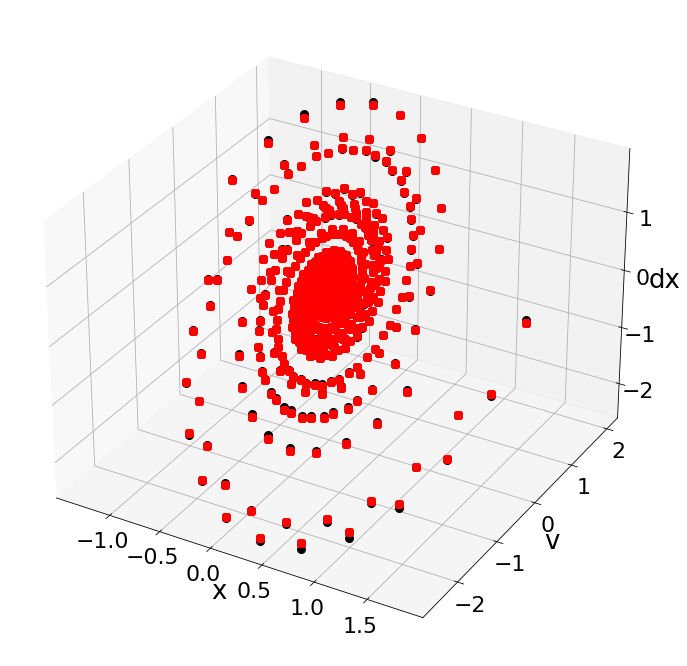

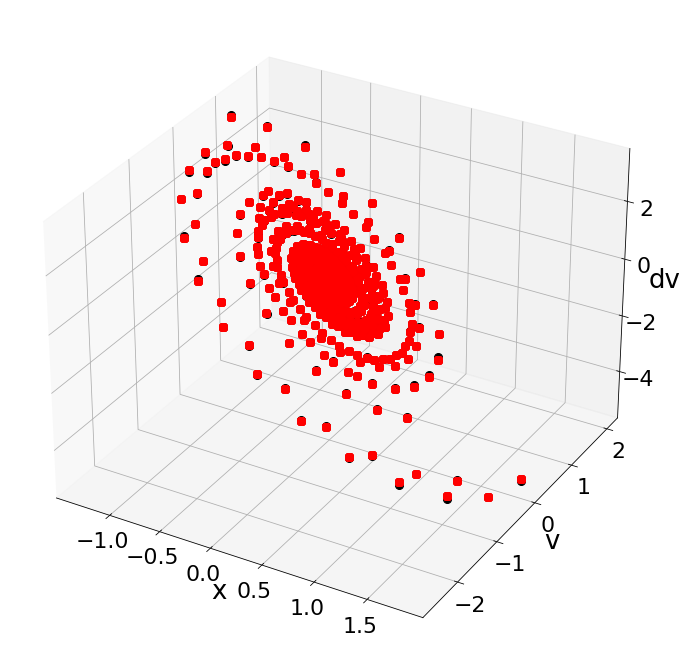

In [9]:
# Plotting Sources vs States

fig  = plt.figure(figsize=(16,12))
ax1  = plt.axes(projection='3d')

fig  = plt.figure(figsize=(16,12))
ax2   = plt.axes(projection='3d')

ax1.plot3D(InputDF[InputData.InputVars[0]], InputDF[InputData.InputVars[1]], OutputDF[InputData.OutputVars[0]], 'ok',  linewidth=2)
ax2.plot3D(InputDF[InputData.InputVars[0]], InputDF[InputData.InputVars[1]], OutputDF[InputData.OutputVars[1]], 'ok',  linewidth=2)

for iSample in range(NSamples):
    yMat = NN.predict(InputDF[InputData.InputVars])
    ax1.plot3D(InputDF[InputData.InputVars[0]], InputDF[InputData.InputVars[1]], yMat[:,0], 'or',  linewidth=2)
    ax2.plot3D(InputDF[InputData.InputVars[0]], InputDF[InputData.InputVars[1]], yMat[:,1], 'or',  linewidth=2)

    ax1.set_xlabel(InputData.InputVars[0])
ax1.set_ylabel(InputData.InputVars[1])
ax1.set_zlabel(InputData.OutputVars[0])

ax2.set_xlabel(InputData.InputVars[0])
ax2.set_ylabel(InputData.InputVars[1])
ax2.set_zlabel(InputData.OutputVars[1])

In [10]:
### Defining Surrogate ODE

def f_NN(t, y):
    #print(t)
    dydt = NN.predict(y[np.newaxis,...])
    return dydt[0,:]

iVar =  1
u0 =  [-1.31420311 -2.52473695]


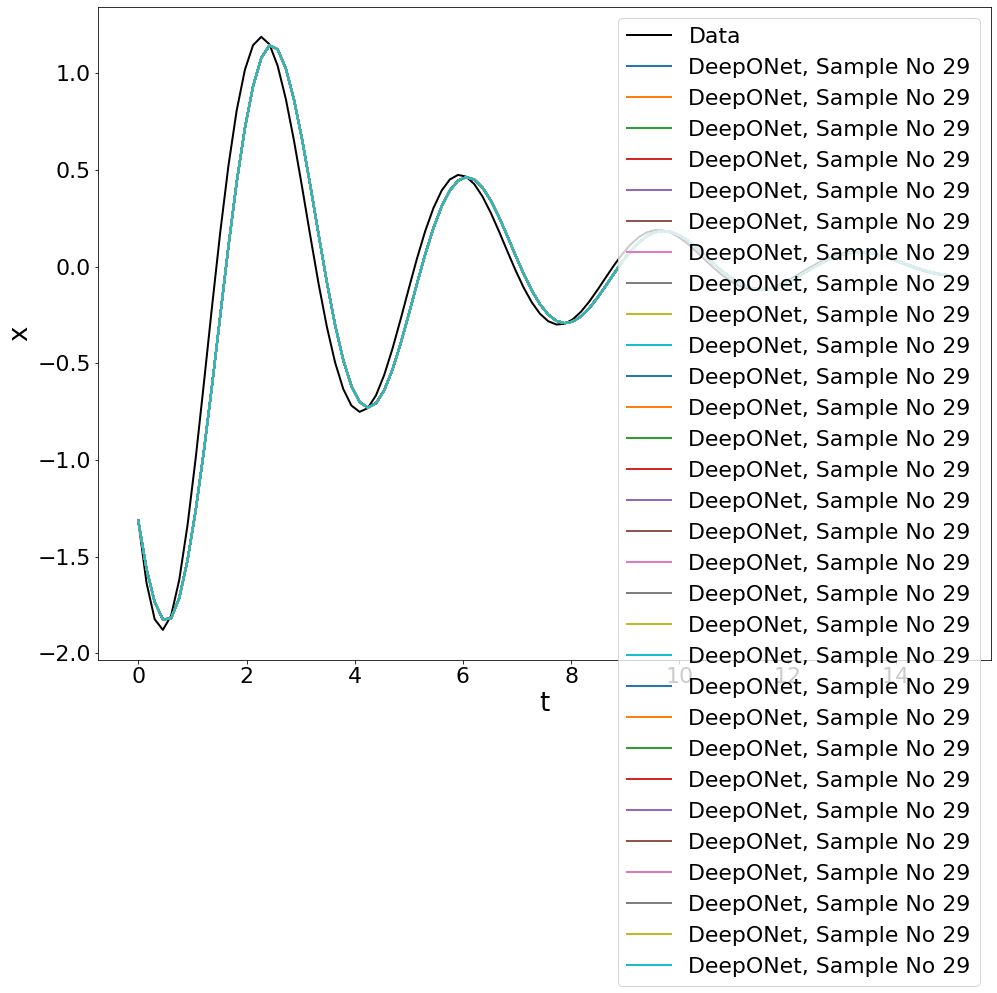

In [11]:
### Evaluating on Training Data


## Variable to Be Visualized
VarOI     = 'x'
for iVar in range(1,len(VarNames)):
    if (VarNames[iVar] == VarOI):
        print('iVar = ', iVar)
        break
       
    
for iTraining in TrainingCases:
    print('u0 = ', u[iTraining,:])
    
    fig = plt.figure(figsize=(16, 12))
    
    
    output     = solve_ivp( fOrig, tout[[0,-1]], u[iTraining,:], method=SOLVER, t_eval=tout, rtol=rtol )
    tOrig      = output.t
    yMatOrig   = output.y.T
    
    plt.plot(tOrig, yMatOrig[:,iVar-1],  'k-', label='Data')
    
    
    for iSamples in range(NSamples):
        if (NSamples == 1):
            Label = 'FNN'
        else:
            Label = 'FNN, Sample No '+str(iSample)
            
        output     = solve_ivp( f_NN, tout[[0,-1]], u[iTraining,:], method=SOLVER, t_eval=tout, rtol=rtol )
        tPred      = output.t
        yMat       = output.y.T

        plt.plot(tPred, yMat[:,iVar-1], '-', label=Label)
    
    
    plt.xlabel('t')
    plt.ylabel(VarOI)
    plt.legend()
    plt.show()

iVar =  1
u0 =  [-1.07856426 -0.82275602]


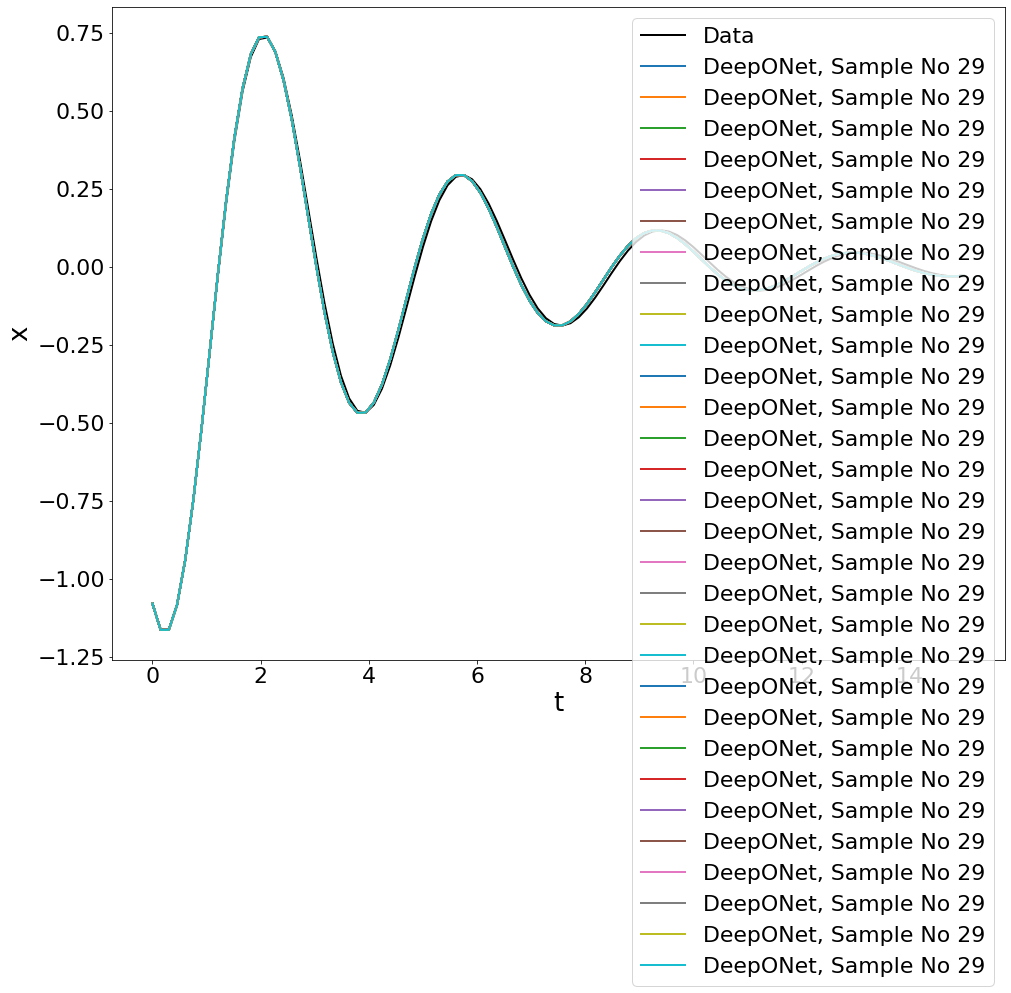

In [12]:
### Evaluating on Test Data

FileName  = InputData.path_to_data_fld + '/test/ext/Input.csv'
Data      = pd.read_csv(FileName, header=0)
Input     = Data[InputData.InputVars].to_numpy()
VarNames  = list(Data.columns)
Nu        = Input.shape[1]
u         = []
for iu in range(Nu):
    u.append(np.unique(Input[:,iu]))
u         = np.stack(u, axis=0).T


## Variable to Be Visualized
VarOI     = 'x'
for iVar in range(1,len(VarNames)):
    if (VarNames[iVar] == VarOI):
        print('iVar = ', iVar)
        break
    
    
for iTest in TestCases:
    print('u0 = ', u[iTest,:])
    
    fig = plt.figure(figsize=(16, 12))
    
    
    output     = solve_ivp( fOrig, tout[[0,-1]], u[iTest,:], method=SOLVER, t_eval=tout, rtol=rtol )
    tOrig      = output.t
    yMatOrig   = output.y.T
    
    plt.plot(tOrig, yMatOrig[:,iVar-1],  'k-', label='Data')
    
    
    for iSamples in range(NSamples):
        if (NSamples == 1):
            Label = 'FNN'
        else:
            Label = 'FNN, Sample No '+str(iSample)
            
        output     = solve_ivp( f_NN, tout[[0,-1]], u[iTest,:], method=SOLVER, t_eval=tout, rtol=rtol )
        tPred      = output.t
        yMat       = output.y.T
                
        plt.plot(tPred, yMat[:,iVar-1], '-', label=Label)
    
        
    plt.xlabel('t')
    plt.ylabel(VarOI)
    plt.legend()
    plt.show()